<a href="https://colab.research.google.com/github/erodola/NumMeth-s2-2022/blob/main/esercizi/ex7/ex7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Benvenuti alla settima esercitazione di Metodi Numerici!

Oggi indagheremo come ottimizzare loss generiche attraverso il metodo della discesa del gradiente. Come al solito iniziamo con alcuni import e download:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from functools import partial

In [ ]:
!wget https://github.com/erodola/NumMeth-s2-2022/raw/main/esercizi/ex7/mountain.png

## Problema 1 - Problema di Fermat–Weber

Una famosa catena di supermercati ha concentrato $n = 40$ punti vendita $\mathbf{x}_i$ nel Lazio (localmente diffeomorfo a $\mathbb{R}^2$). Avendo investito tutti i suoi soldi nei sudetti centri, la catena può costruire soltanto un deposito rifornimenti $\mathbf{y}$. Si vuole trovare il punto geografico in cui posizionare tale deposito, in modo da minimizzare la distanza complessiva tra esso e i diversi supermercati $\{\mathbf{x}_i\}$. Inoltre alcuni supermercati si trovano in aree popolate più densamente, quindi bisogna dare a loro la precedenza nei rifornimenti, anche se potrebbero risultare più distanti dagli altri negozi. Per indicare l'importanza di ogni supermercato, possiamo usare un vettore di scalari positivi $\mathbf{w} \in \mathbb{R}^n$. Disponiamo i diversi supermercati e scegliamo il vettore $\mathbf{w}$ (`weights`):

In [ ]:
n = 40
sigma = 2
X = sigma*np.concatenate([np.random.randn(n//2, 2), np.random.randn(n//2, 2) + 3])
weights = np.random.rand(n)

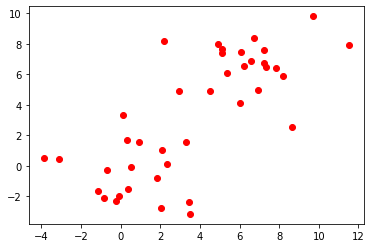

In [ ]:
plt.scatter(X[:, 0], X[:, 1], color='r')

In [ ]:
print(f"weights = {weights}")

weights = [0.23430109 0.41793879 0.99132238 0.12536366 0.14476346 0.22989232
 0.99254861 0.55049542 0.06953797 0.65082352 0.14660839 0.61499058
 0.3448353  0.14691746 0.52309358 0.14714154 0.43475181 0.56776351
 0.50591128 0.12611064 0.00425453 0.93661617 0.40147668 0.1822077
 0.78988888 0.52919405 0.17604842 0.41416202 0.68272041 0.83146893
 0.49744492 0.91335232 0.58402083 0.23320874 0.71878372 0.81510893
 0.51143183 0.19409205 0.8880316  0.23190203]


Il problema descritto è un'istanza del problema matematico di *Fermat-Weber*, il quale richiede di trovare la mediana geometrica pesata di un insieme di punti. Possiamo descriverlo attraverso il seguente problema di ottimizzazione: $$ \min_{\mathbf{y}}\sum_{i} w_i \Vert \mathbf{y} - \mathbf{x}_i \Vert_2.$$ Per trovare la soluzione del problema vogliamo procedere in modo simile a come abbiamo fatto nel caso dei minimi quadrati, ossia calcolare il gradiente $\nabla_\mathbf{y}f(\mathbf{y})$ e imporre che sia uguale a 0. Consultiamo il Matrix cookbook per calcolare il gradiente:
$$\nabla_\mathbf{y} \sum_{i} w_i \Vert \mathbf{y} - \mathbf{x}_i \Vert_2 = \sum_{i} w_i \nabla_\mathbf{y} \Vert \mathbf{y} - \mathbf{x}_i \Vert_2  = \sum_{i} w_i \frac{\mathbf{y} - \mathbf{x}_i} {\Vert \mathbf{y} - \mathbf{x}_i \Vert_2} $$.

Visualizziamo il valore della funzione $f(\mathbf{y}) = \sum_{i} w_i \Vert \mathbf{y} - \mathbf{x}_i \Vert_2$ in $\mathbb{R}^2$ e il relativo campo di gradienti:

In [ ]:
grid_n = 100
min_x = np.min(X[:, 0])
max_x = np.max(X[:, 0])
min_y = np.min(X[:, 1])
max_y = np.max(X[:, 1])
margin = 0.2
X_grid, Y_grid = np.meshgrid(np.linspace(min_x-margin, max_x+margin, grid_n), np.linspace(min_y-margin, max_y+margin, grid_n))

In [ ]:
Z = np.sqrt((((X_grid.reshape(grid_n, grid_n, 1) - X[:, 0].reshape(1, 1, n))**2) + (
            (Y_grid.reshape(grid_n, grid_n, 1) - X[:, 1].reshape(1, 1, n)) ** 2))).sum(axis=-1)

In [ ]:
Z_grid = (np.sqrt((((X_grid.reshape(grid_n, grid_n, 1) - X[:, 0].reshape(1, 1, n))**2) + (
        (Y_grid.reshape(grid_n, grid_n, 1) - X[:, 1].reshape(1, 1, n)) ** 2))) * weights.reshape(1, 1, n)).sum(axis=-1)

In [ ]:
grad_X = ( ((X_grid.reshape(grid_n, grid_n, 1) - X[:, 0].reshape(1, 1, n))) / (np.sqrt((((X_grid.reshape(grid_n, grid_n, 1) - X[:, 0].reshape(1, 1, n))**2) + (
        (Y_grid.reshape(grid_n, grid_n, 1) - X[:, 1].reshape(1, 1, n)) ** 2)))) * weights.reshape(1, 1, n) ).sum(axis=-1)
grad_Y = ( ((Y_grid.reshape(grid_n, grid_n, 1) - X[:, 1].reshape(1, 1, n))) / (np.sqrt((((X_grid.reshape(grid_n, grid_n, 1) - X[:, 0].reshape(1, 1, n))**2) + (
        (Y_grid.reshape(grid_n, grid_n, 1) - X[:, 1].reshape(1, 1, n)) ** 2)))) * weights.reshape(1, 1, n) ).sum(axis=-1)

# prune grad_X, grad_Y
prune_factor = 5
pruned_grad_X = grad_X[np.ix_(range(0, grid_n, prune_factor), range(0, grid_n, prune_factor))]
pruned_grad_Y = grad_Y[np.ix_(range(0, grid_n, prune_factor), range(0, grid_n, prune_factor))]
pruned_X_grid = X_grid[np.ix_(range(0, grid_n, prune_factor), range(0, grid_n, prune_factor))]
pruned_Y_grid = Y_grid[np.ix_(range(0, grid_n, prune_factor), range(0, grid_n, prune_factor))]

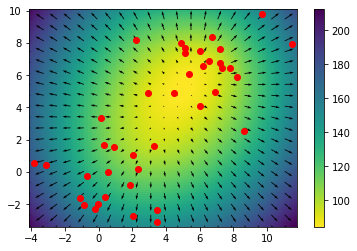

In [ ]:
plt.pcolormesh(X_grid, Y_grid, Z_grid, cmap=cm.viridis_r)
plt.colorbar()
plt.quiver(pruned_X_grid, pruned_Y_grid, pruned_grad_X, pruned_grad_Y, units='width')
plt.scatter(X[:, 0], X[:, 1], color='r')

Notiamo empiricamente che la loss del problema è una funzione convessa, quindi ammette un'unico minimo (globale). Purtroppo è stato dimostrato che in generale l'equazione $\sum_{i} w_i \frac{\mathbf{y} - \mathbf{x}_i} {\Vert \mathbf{y} - \mathbf{x}_i \Vert_2}= 0$ non può essere risolta rispetto a $\mathbf{y}$ in forma chiusa. Possiamo però sfruttare il gradiente per spostarci da una vettore iniziale $\mathbf{y}_0$ verso la soluzione. A tal fine adoperiamo il metodo della *discesa del gradiente*:

In [ ]:
def gradient_descent(grad_fn, loss_fn, alphas, init):
    xs = [init]
    losses = []
    x = init
    for alpha in alphas:
        loss = loss_fn(x)
        x = x - alpha * grad_fn(x)
        xs.append(x)
        losses.append(loss)
    return xs, losses

In [ ]:
def grad_weber(y, X, weights):
    return np.sum((weights[:,np.newaxis]*(y - X))/(np.linalg.norm(X - y, axis=-1))[:,np.newaxis], axis=0)

def loss_weber(y, X, weights):
    return np.sum(weights[:,np.newaxis]*(np.linalg.norm(y - X, axis=-1))[:,np.newaxis], axis=0)

In [ ]:
max_t = 50
alphas = [0.05]*max_t
init = np.array([[0., 0.]])
ys, losses = gradient_descent(partial(grad_weber, X=X, weights=weights),
                              partial(loss_weber, X=X, weights=weights),
                              alphas=alphas,
                              init = init)

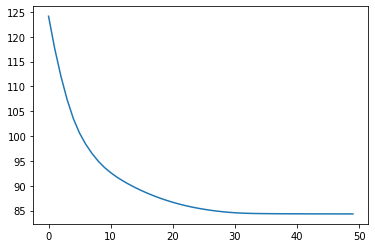

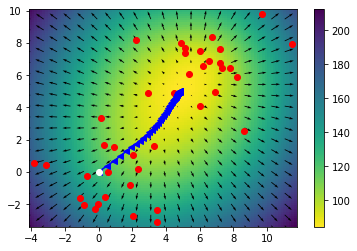

In [ ]:
trajectory = np.concatenate(ys)
plt.figure()
plt.plot(losses)

plt.figure()
plt.pcolormesh(X_grid, Y_grid, Z_grid, cmap=cm.viridis_r)
plt.colorbar()
plt.quiver(pruned_X_grid, pruned_Y_grid, pruned_grad_X, pruned_grad_Y, units='width')
plt.scatter(X[:, 0], X[:, 1], color='r')
plt.plot(trajectory[:, 0], trajectory[:, 1], 'b<-')
plt.plot(trajectory[0:1, 0], trajectory[0:1, 1], 'wo-')

#### Esercizi
1. Verifica cosa succede quando $\alpha = 0.001$ e $\alpha = 0.5$ a parità di `max_t` mantenendo $\mathbf{y}_0 = (0,0)$
2. Prova diversi punti di inizializzazione con $\alpha = 0.05$

## Problema 2 - Regressione lineare con discesa del gradiente

1. Generare dati artificiali in 2D relativamente a una retta ground truth.
2. Scrivere le funzioni `loss_ls` e `grad_ls` relative alla regressione lineare usando il metodo dei minimi quadrati.
3. Plottare l'energia `loss_ls` nel piano e il campo vettoriale `grad_ls` relativo.
4. Risolvere il problema dei minimi quadrati usando la discesa del gradiente (fare plug-in delle funzioni `grad_ls` e `loss_ls` dentro la funzione `gradient_descent` definita al punto precedente.
5. Plottare la traiettoria delle soluzioni nel piano e confrontare il risultato con il ground truth.
6. Confronta con il risultato ottenuto attraverso la formula chiusa.

In [ ]:
sigma_squared_x = 2.
sigma_squared_y = 3.
a_gt = 3.
b_gt = 2.

x = ...
y_gt = ...
z_y = ...
y = ...

In [ ]:
# plt.scatter(x, y)
# plt.plot(np.arange(x.min(),x.max() + 1), a_gt*np.arange(x.min(),x.max()+1) + b_gt, '--r')

In [ ]:
def grad_ls(w, X, y):
    ...

def loss_ls(w, X, y):
    ...

In [ ]:
X = ...
Y = ...

In [ ]:
grid_n = 100
min_x = -10
max_x = 10
min_y = -10
max_y = 10
margin = 0.2
w_X_grid, w_Y_grid = np.meshgrid(np.linspace(min_x-margin, max_x+margin, grid_n), np.linspace(min_y-margin, max_y+margin, grid_n))

In [ ]:
w_Z_grid = np.zeros((grid_n, grid_n))
w_X_grad = np.zeros((grid_n, grid_n))
w_Y_grad = np.zeros((grid_n, grid_n))

for i in range(grid_n):
    for j in range(grid_n):
        w_i_j = ...
        w_Z_grid[i,j] = ...
        grad_w_i_j = ...
        w_X_grad[i,j] = ...
        w_Y_grad[i,j] = ...

prune_factor = 5
pruned_w_X_grad = w_X_grad[np.ix_(range(0, grid_n, prune_factor), range(0, grid_n, prune_factor))]
pruned_w_Y_grad = w_Y_grad[np.ix_(range(0, grid_n, prune_factor), range(0, grid_n, prune_factor))]
pruned_w_X_grid = w_X_grid[np.ix_(range(0, grid_n, prune_factor), range(0, grid_n, prune_factor))]
pruned_w_Y_grid = w_Y_grid[np.ix_(range(0, grid_n, prune_factor), range(0, grid_n, prune_factor))]

In [ ]:
plt.pcolormesh(w_X_grid, w_Y_grid, w_Z_grid, cmap=cm.viridis_r)
plt.colorbar()
plt.quiver(pruned_w_X_grid, pruned_w_Y_grid, pruned_w_X_grad, pruned_w_Y_grad, units='width')

In [ ]:
# scegliere dei valori per max_t, alpha e w_0
max_t = ...
alphas = ...
w_0 = ...
ws, losses = gradient_descent(partial(grad_ls, X=X, y=Y),
                              partial(loss_ls, X=X, y=Y),
                              alphas=alphas,
                              init = w_0)
print(ws[-1])

In [ ]:
trajectory = np.concatenate(ws, axis=-1).T
plt.figure()
plt.plot(losses)

plt.figure()
plt.pcolormesh(w_X_grid, w_Y_grid, w_Z_grid, cmap=cm.viridis_r)
plt.colorbar()
plt.quiver(pruned_w_X_grid, pruned_w_Y_grid, pruned_w_X_grad, pruned_w_Y_grad, units='width')
plt.plot(trajectory[:, 0], trajectory[:, 1], 'b>-')
plt.plot(trajectory[0:1, 0], trajectory[0:1, 1], 'wo-')

In [ ]:
# trovare w in forma chiusa
w_closed = ...
print(w_closed)

## Problema 3 - Regressione logistica

Un metodo elementare ma potente per poter effettuare la classificazione dei dati è la *regressione logistica*. Supponiamo di disporre di un insieme di immagini $\mathbf{x}_i$ contententi 0 e 1 scritti a mano. Vogliamo avere un modello che permette di classificare come $y = 0$ ( $y = 1$) un'immagine in cui compare scritto lo zero (l'uno). Carichiamo i dati dal dataset MNIST (che abbiamo incontrato anche all'Esercitazione 5).


In [ ]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[ (y_train == 0) | (y_train == 1), :, :]
X_train = X_train / np.max(X_train)
y_train = y_train[(y_train == 0) | (y_train == 1)]

X_test = X_test[ (y_test == 0) | (y_test == 1), :, :]
X_test = X_test / np.max(X_test)
y_test = y_test[(y_test == 0) | (y_test == 1)]

y = y_train[..., np.newaxis]
X = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
n = X.shape[1]
w = np.zeros((n,1))

Nella regressione logistica, l'output del modello è una probabilità $p_i$, la quale indica la probabilita che un dato $\mathbf{x}_i$ rappresenti la classe 1 (la probabilità con cui rappresenta 0 è $1 - p_i$). Infatti viene cercata la soluzione al seguente problema di minimizzazione: $$\min_{\mathbf{w}} J(\mathbf{x}) = \min_{\mathbf{w}}  -\left[ \mathbf{y}^T \log(\sigma(\mathbf{X}\mathbf{w} + \epsilon)) + (\mathbf{1} - \mathbf{y})^T \log(\mathbf{1} - \sigma(\mathbf{X}\mathbf{w} + \epsilon))\right],$$ dove $\mathbf{1}$ è il vettore di tutti 1, $\mathbf{y}$ contiene 0 o 1 in ogni entrata $y_i$, $\epsilon$ è un valore piccolo (per esempio `1e-5`) per rendere il logaritmo stabile numericamente e $\sigma$ è la cosidetta *funzione logistica* (*sigmoide logistica*): $$\sigma(x) = \frac{1}{1 + e^{-x}}$$



In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

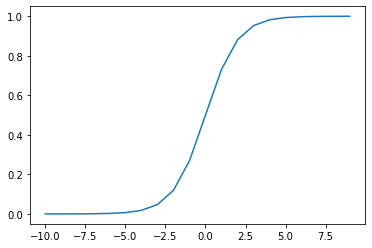

In [ ]:
plt.plot(np.arange(-10, 10), sigmoid(np.arange(-10, 10)))

La loss da ottimizzare può risultare ostica a prima vista e trova la sua giustificazione nella teoria della probabilità. Non bisogna comprenderla appieno ai fini di questo esercizio (il focus è sulla discesa del gradiente). L'idea di fondo è quella di abbassare l'output di $\sigma(\mathbf{x}_i^T\mathbf{w})$ dove $y = 0$ e alzarlo nel caso contrario. La funzione $\sigma$ è necessaria per rendere i valori di $\mathbf{x}_i^T\mathbf{w}$ compresi tra 0 e 1 (quindi delle probabilità). Un aspetto molto interessante è la forma del gradiente. Effettuando i diversi passaggi del calcolo del gradiente (per chi fosse interessato può consultare questa [pagina](https://stats.stackexchange.com/questions/278866/derive-logistic-loss-gradient-in-matrix-form)) otteniamo:
$$\nabla_{\mathbf{w}} J(\mathbf{w})= \mathbf{X}^T(\sigma(\mathbf{X}\mathbf{w})- \mathbf{y}).$$ Abbiamo la stessa espressione del gradiente incontrato nella regressione dei minimi quadrati, con la differenza che $\mathbf{X}\mathbf{w}$ è input dalla nonlinearità $\sigma$! Questo cambiamento rende il gradiente non risolvibile in forma chiusa (pur essendo di nuovo il gradiente di una loss convessa) e perciò bisogna di nuovo affidarsi alla discesa del gradiente.

#### Esercizi
1. Scrivere le funzioni `loss_logistic` e `grad_logistic` usando l'espressione della loss e del gradiente descritti precedentemente
2. Trovare una soluzione `w_final` usando la discesa del gradiente e plottare le loss intermedie.
3. Effettuare la predizione della classe usando `w_final` sui primi due dati di test, poi iterare il dataset di test per calcolare l'accuratezza del modello.
4. Plottare un esempio classificato in modo sbagliato (se esiste) e la relativa probabilita'.

In [ ]:
def grad_logistic(w, y, X):
    ...

def loss_logistic(w, y, X):
    epsilon = 1e-5
    ...

In [ ]:
max_t = ...
alphas = ...
grad_fn = partial(grad_logistic, X=X, y=y)
loss_fn = partial(loss_logistic, X=X, y=y)

ws, losses = gradient_descent(grad_fn, loss_fn, alphas, init=w)
w_final = ws[-1]

In [ ]:
plt.plot(losses)

In [ ]:
test_1 = X_test[0]
test_2 = X_test[1]
plt.imshow(test_1)
plt.figure()
plt.imshow(test_2)
h_1 = ...
print(f"h_1 = {...}")
h_2 = ...
print(f"h_2 = {...}")

In [ ]:
predictions = ...
diff = ...
miss = ...
accuracy = ...
print(f"accuracy = {accuracy}")

print(f"h_bad = ...")

 ## Problema 4 - Denoising

Adesso abbiamo tutti gli strumenti per risolvere l'ultimo problema dell'Esercitazione 3 (il denoising di un'immagine) senza dover ricorrere all'inversione di una matrice molto grande o effettuare il denoising su chunk locali. Per prima cosa carichiamo l'immagine:

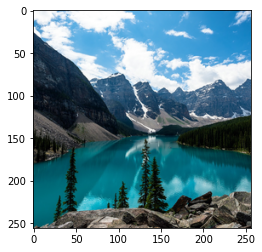

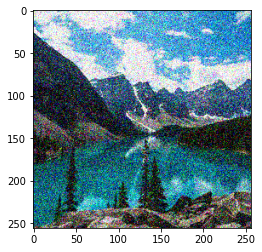

In [ ]:
from PIL import Image
im = Image.open('mountain.png')

sigma_square = 0.2
alpha = 1.
n = 256
chunk_size = 32

# trasformiamo in un vettore np dopo aver normalizzato
pix = im / np.max(im)
# pix = pix[:, :, 0]
# print(x)

# plottiamo l'immagine
plt.figure()
plt.imshow(pix)

# creare rumore e aggiungere al dato
z = sigma_square*np.random.randn(pix.shape[0], pix.shape[1], pix.shape[2])

pix_noisy = pix + z
pix_noisy = np.clip(pix_noisy, 0., 1.)

# plottiamo l'immagine noisy
plt.figure()
plt.imshow(pix_noisy)

Vogliamo risolvere il problema usando la seguente loss (su ogni canale): $$\min_{\mathbf{y}} \Vert \mathbf{y} - \mathbf{x} \Vert^2_2 + \lambda \Vert \nabla\mathbf{y}\Vert_2^2$$
Ricordiamo che questa loss è un problema least squares con regolarizzazione della smoothness. Diversamente dall'Esercitazione 3, vogliamo denoisare il segnale considerando il gradiente su entrambe le direzioni $(x, y)$. A tal fine calcoliamo il gradiente dell'obiettivo ottenendo (verificare il primo membro su Matrix cookbook) $$(\mathbf{y} - \mathbf{x}) + \lambda \nabla \Vert \nabla\mathbf{y}\Vert_2^2.$$ Il secondo termine può risultare difficile da risolvere. La quantità $\Vert \nabla \mathbf{y}\Vert_2^2$ è detta *energia di Dirichlet*, essendo la norma del campo gradiente (l'integrale delle norme dei gradienti su tutto il segnale) indica quanto varia il segnale. Si dimostra che il gradiente di questa quantita (rispetto a tutto il segnale, qui tecnicamente si dovrebbe parlare di calcolo delle variazioni) è uguale al Laplaciano del segnale!
$$ \lambda \nabla \Vert \nabla\mathbf{y}\Vert_2^2 = \lambda \Delta \mathbf{y},$$ dove $$\Delta \mathbf{y} = \frac{\partial^2\mathbf{y}}{\partial x^2} + \frac{\partial^2\mathbf{y}}{\partial y^2}.$$

#### Esercizi

1. Sappiamo che possiamo calcolare il gradiente discreto di un segnale `y` usando `np.gradient`. Calcolando su queste quantità nuovamente `np.gradient` possiamo ottenere le derivate seconde. Usare questa informazione per definire `grad_smoothness`. Definire anche `loss_smoothness` (qui servono solo le derivate prime).
2. Risolvere il problema di denoising usando la discesa del gradiente (riportiamo una versione modificata che normalizza l'immagine ad ogni step). Plottare loss intermedie.

In [ ]:
def grad_smoothness(y, x, lmbd=1.):
    gx_r, gy_r = ..., ...
    gx_g, gy_g = ..., ...
    gx_b, gy_b = ..., ...

    gxx_r, _ = ..., ...
    _, gyy_r =  ..., ...

    gxx_g, _ = ..., ...
    _, gyy_g = ..., ...

    gxx_b, _ = ..., ...
    _, gyy_b = ..., ...

    laplace_r = ...
    laplace_g = ...
    laplace_b = ...

    laplace = np.concatenate([laplace_r, laplace_g, laplace_b], axis=-1)
    return ...

def loss_smoothness(y, x, lmbd=1.):
    gx_r, gy_r = ..., ...
    gx_g, gy_g = ..., ...
    gx_b, gy_b = ..., ...

    return ...

In [ ]:
def gradient_descent_with_image_normalization(grad_fn, loss_fn, alphas, init):
    xs = [init]
    losses = []
    x = init
    for alpha in alphas:
        loss = loss_fn(x)
        x = x - alpha * grad_fn(x)
        x[:, :, 0] = np.clip(x[:, :, 0], 0, 1)
        x[:, :, 1] = np.clip(x[:, :, 1], 0, 1)
        x[:, :, 2] = np.clip(x[:, :, 2], 0, 1)
        xs.append(x)
        losses.append(loss)
    return xs, losses

In [ ]:
max_t = ...
alphas = ...
# conviene partire dalla pix_noisy
y_0 = pix_noisy
lmbd = ...

ys, losses = gradient_descent_with_image_normalization(partial(grad_smoothness, x=pix_noisy, lmbd=lmbd),
                              partial(loss_smoothness, x=pix_noisy, lmbd=lmbd),
                              alphas=alphas,
                              init = y_0)

plt.figure()
plt.plot(losses)

for i, y in enumerate(ys):
    if i % 10 == 0:
        plt.figure()
        plt.imshow(y)

## Esericizo 5 - $\alpha$ adattativo

1. Scrivere una funzione che restituisce uno schedule di $\alpha$ per ognuno dei tre schedules visti a lezione (e visualizzare degli esempi):
    a. $\alpha^{(t+1)}= (1-\frac{t}{\rho})\alpha^{(0)} + \frac{t}{\rho}\alpha^{(\rho)}$
    b. $\alpha^{(t+1)}= \frac{\alpha^{(t)}}{1+\rho t}$
    c. $\alpha^{(t+1)}= \alpha^{(0)} e^{-\rho t}$
2. Scrivere una funzione generica di ottimizzazione (simile a `gradient_descent`) che usa il *momentum*.
3. Provare la discesa del gradiente adattativa sugli esempi visti precedentemente e stimare le differenze nella velocità di convergenza.

In [ ]:
def decay_1(alpha_0, alpha_rho, max_t):
    ...

def decay_2(alpha_0, max_t, rho):
    ...

def decay_3(alpha_0, max_t, rho):
    ...

In [ ]:
alphas_1 = decay_1(alpha_0=0.01, alpha_rho=0.0001, max_t=50)
alphas_2 = decay_2(alpha_0=0.01, max_t=50, rho=0.01)
alphas_3 = decay_3(alpha_0=0.01, max_t=50, rho=0.05)

plt.plot(alphas_1)
plt.plot(alphas_2)
plt.plot(alphas_3)
plt.legend(["Linear", "Recurrent", "Exponential"])

In [ ]:
def gradient_descent_momentum(grad_fn, loss_fn, alphas, init, init_v, lmbd):
    ...

## Bonus - JAX Live Demo

Stanchi di calcolare a mano i gradienti! Abbiamo il prodotto che fa per voi! Si chiama JAX!

In [1]:
# spazio lasciato per sua maestà JAX
import jax